In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal, wilcoxon, friedmanchisquare
from statsmodels.stats.multitest import multipletests


In [2]:
path = '../data/results-2026-01-23-115413/results.csv'
path = '../data/results-2026-01-23-204650/results.csv'

# df = pd.read_csv('../data/results-2026-01-08-190113.csv', index_col=0)
df_raw = pd.read_csv(path, index_col=None)

cols_of_interest = ['total_faults', 'faults_detected', 'fdl', 'test_suite', 'language', 'budget_prop_requested', 'random_seed', 'method', 'algorithm_family', 'representation']


df = df_raw[cols_of_interest].rename(columns={"budget_prop_requested": "budget"}).copy()
df = df[df['language'] == "C"]


In [3]:
df.head()

,total_faults,faults_detected,fdl,test_suite,language,budget,random_seed,method,algorithm_family,representation
2000,9,6,0.333333,flex_v3,C,0.1,166766486,cs_tf_srp,cs,tf_srp
2001,9,6,0.333333,flex_v3,C,0.2,166766486,cs_tf_srp,cs,tf_srp
2002,9,6,0.333333,flex_v3,C,0.3,166766486,cs_tf_srp,cs,tf_srp
2003,9,6,0.333333,flex_v3,C,0.4,166766486,cs_tf_srp,cs,tf_srp
2004,9,9,0.000000,flex_v3,C,0.5,166766486,cs_tf_srp,cs,tf_srp


In [4]:
df.groupby(by=["method"]).agg({
    "total_faults": "mean",
    "faults_detected": "mean",
    "fdl": "mean",
}).reset_index()

,method,total_faults,faults_detected,fdl
0,cs_emb,9.8,8.418,0.099671
1,cs_tf_srp,9.8,8.172,0.120210
2,pp_emb,9.8,8.662,0.076190
3,pp_tf_srp,9.8,8.200,0.115769


In [5]:
pivot = df.pivot(columns='method', index=['test_suite', 'budget', 'random_seed'], values='fdl')

pivot.head()

method                           cs_emb  cs_tf_srp    pp_emb  pp_tf_srp
test_suite budget random_seed                                          
flex_v3    0.1    166169421    0.444444   0.444444  0.222222   0.333333
                  166766486    0.222222   0.333333  0.111111   0.333333
                  546794661    0.111111   0.000000  0.222222   0.444444
                  1237048289   0.222222   0.333333  0.222222   0.444444
                  2056722027   0.222222   0.444444  0.111111   0.333333

In [6]:
friedman_results = friedmanchisquare(pivot['cs_tf_srp'], pivot['cs_emb'], pivot['pp_tf_srp'], pivot['pp_emb'])

print(f"Friedman test statistic: {friedman_results.statistic}, p-value: {friedman_results.pvalue}")

if friedman_results.pvalue < 0.05:
    print("Significant differences found between methods, proceeding to pairwise Wilcoxon tests.")

Friedman test statistic: 56.91108840061226, p-value: 2.684677527565917e-12
Significant differences found between methods, proceeding to pairwise Wilcoxon tests.


In [7]:
results = []
for method1 in df['method'].unique():
    for method2 in df['method'].unique():
        if method1 == method2:
            continue

        test_result = wilcoxon(pivot[method1], pivot[method2], alternative = 'less')
        
        result = {
            "method1": method1,
            "method2": method2,
            "pval": test_result.pvalue,
        }

        results.append(result)

results = pd.DataFrame(results)
results["reject"] = multipletests(results['pval'], alpha=0.05, method='holm')[0]
results["p_adj"] = multipletests(results['pval'], alpha=0.05, method='holm')[1]

results.sort_values(by='p_adj')

,method1,method2,pval,reject,p_adj
9,pp_emb,cs_tf_srp,2.010560e-10,True,2.412673e-09
11,pp_emb,pp_tf_srp,3.912315e-08,True,4.303547e-07
10,pp_emb,cs_emb,2.762523e-05,True,2.762523e-04
3,cs_emb,cs_tf_srp,7.300452e-04,True,6.570407e-03
4,cs_emb,pp_tf_srp,2.501901e-03,True,2.001521e-02
0,cs_tf_srp,cs_emb,9.992700e-01,False,1.000000e+00
1,cs_tf_srp,pp_tf_srp,5.978749e-01,False,1.000000e+00
2,cs_tf_srp,pp_emb,1.000000e+00,False,1.000000e+00
5,cs_emb,pp_emb,9.999724e-01,False,1.000000e+00
6,pp_tf_srp,cs_tf_srp,4.021251e-01,False,1.000000e+00


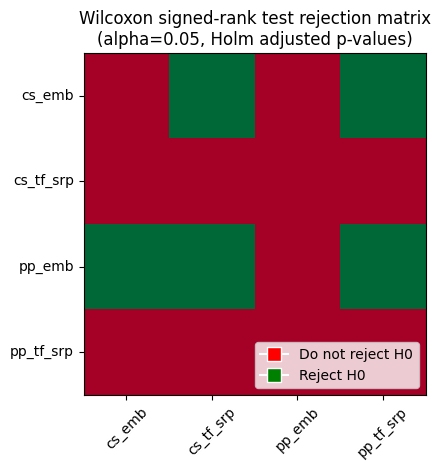

In [8]:
rejection_mat = results.pivot_table(values="reject", index='method1', columns='method2').fillna(0)

ax = plt.imshow(rejection_mat.to_numpy(), cmap='RdYlGn', vmin=0, vmax=1)
# binary legend instead of continuous
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color='w', label='Do not reject H0', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='s', color='w', label='Reject H0', markerfacecolor='green', markersize=10)], loc='lower right')

plt.xticks(ticks=np.arange(len(rejection_mat.columns)), labels=rejection_mat.columns, rotation=45)
plt.yticks(ticks=np.arange(len(rejection_mat.index)), labels=rejection_mat.index, rotation=0, va='center')

plt.title("Wilcoxon signed-rank test rejection matrix\n(alpha=0.05, Holm adjusted p-values)")
plt.tight_layout()
plt.show()

In [9]:
df = df_raw.copy()

df = df[df['representation'] != 'SuiteLength']
df['total_time'] = df['preperation_time_ns'] + df['reduction_time_ns']
df['reduction_time_s'] = df['reduction_time_ns'] / 1e9  # convert to s
df['preparation_time_s'] = df['preperation_time_ns'] / 1e9  # convert to s

df['reduction_time_s_normalized'] = df['reduction_time_s'] / df['n_total_tests']
df['preparation_time_s_normalized'] = df['preparation_time_s'] / df['n_total_tests']
df['total_time_normalized'] = (df['preparation_time_s'] + df['reduction_time_s']) / df['n_total_tests']

df.columns

Index(['total_faults', 'faults_detected', 'preperation_time_ns',
       'reduction_time_ns', 'fft', 'tsr', 'fdl', 'apfd', 'timestamp_utc',
       'test_suite', 'program', 'version', 'language', 'n_total_tests',
       'budget_prop_requested', 'n_selected', 'budget_prop_achieved', 'run_id',
       'random_seed', 'method', 'algorithm_family', 'representation',
       'total_time', 'reduction_time_s', 'preparation_time_s',
       'reduction_time_s_normalized', 'preparation_time_s_normalized',
       'total_time_normalized'],
      dtype='object')

<Axes: xlabel='reduction_time_s_normalized', ylabel='Density'>

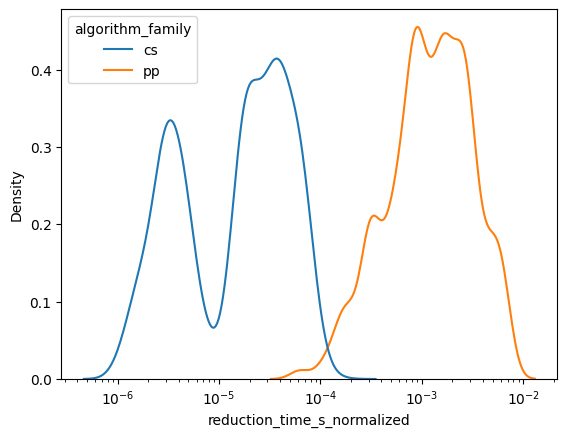

In [10]:
sns.kdeplot(df, x="reduction_time_s_normalized", hue="algorithm_family", log_scale=True)

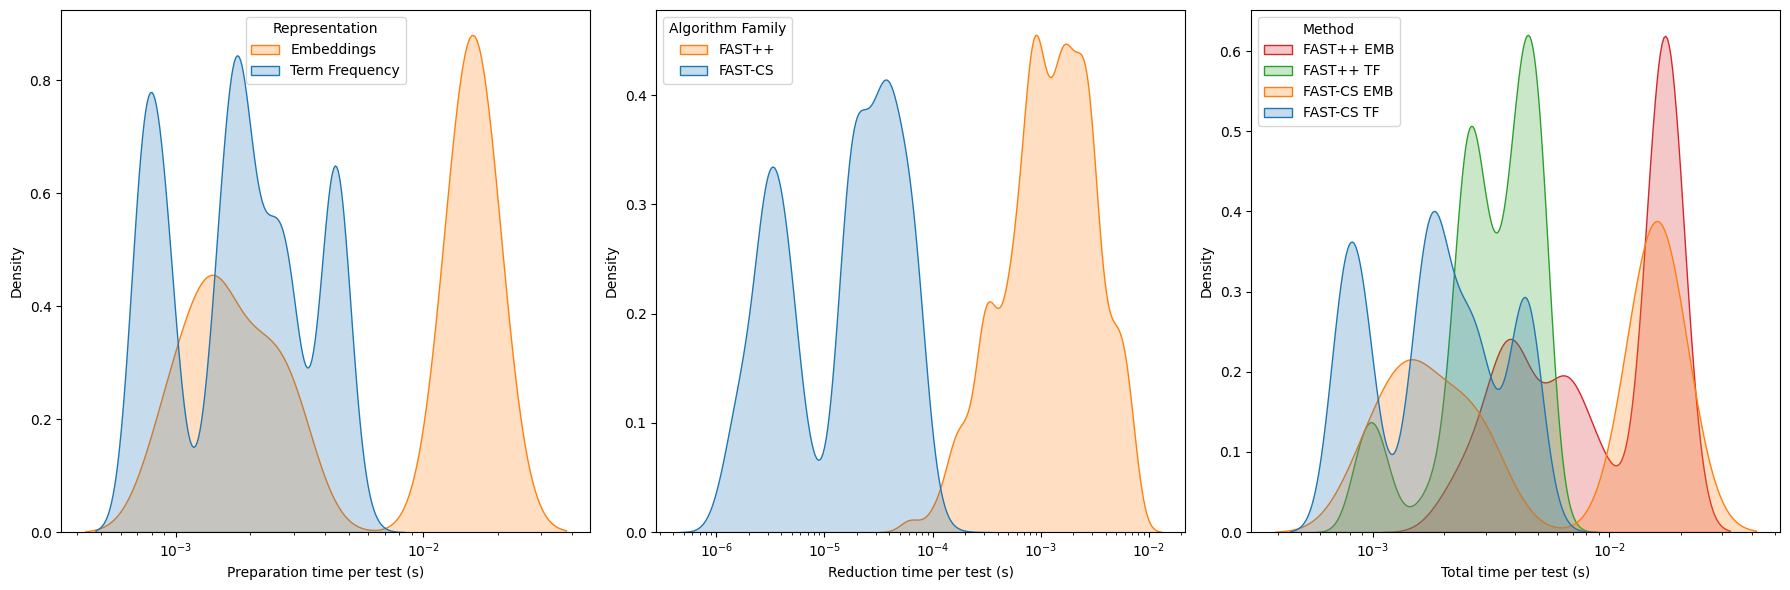

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))


df['Preparation time per test (s)'] = df['preparation_time_s_normalized']
df['Reduction time per test (s)'] = df['reduction_time_s_normalized']
df['Total time per test (s)'] = df['total_time_normalized']

sns.kdeplot(df, x="Preparation time per test (s)", hue="representation", log_scale=True, ax=ax[0], fill=True)
sns.kdeplot(df, x="Reduction time per test (s)", hue="algorithm_family", log_scale=True, ax=ax[1], fill=True)
sns.kdeplot(df, x="Total time per test (s)", hue="method", log_scale=True, ax=ax[2], fill=True)

# Change legend entries
ax[0].legend(title='Representation', labels=['Embeddings', 'Term Frequency'], loc='upper center')
ax[1].legend(title='Algorithm Family', labels=['FAST++', 'FAST-CS'])
ax[2].legend(title='Method', labels=['FAST++ EMB', 'FAST++ TF', 'FAST-CS EMB', 'FAST-CS TF'])

plt.tight_layout()

plt.savefig('../outputs/processing_time_distributions.png', dpi=300)

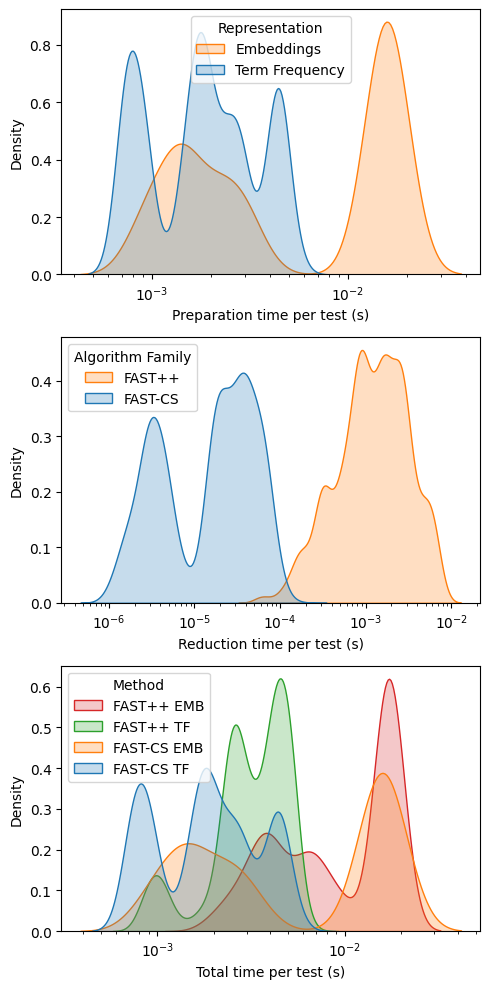

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(5, 10), sharex=False)

sns.kdeplot(df, x="Preparation time per test (s)", hue="representation", log_scale=True, ax=ax[0], fill=True)
sns.kdeplot(df, x="Reduction time per test (s)", hue="algorithm_family", log_scale=True, ax=ax[1], fill=True)
sns.kdeplot(df, x="Total time per test (s)", hue="method", log_scale=True, ax=ax[2], fill=True)

# Change legend entries
ax[0].legend(title='Representation', labels=['Embeddings', 'Term Frequency'], loc='upper center')
ax[1].legend(title='Algorithm Family', labels=['FAST++', 'FAST-CS'])
ax[2].legend(title='Method', labels=['FAST++ EMB', 'FAST++ TF', 'FAST-CS EMB', 'FAST-CS TF'])

plt.tight_layout()

plt.savefig('../outputs/processing_time_distributions.png', dpi=300)

<Axes: xlabel='total_time_normalized', ylabel='Density'>

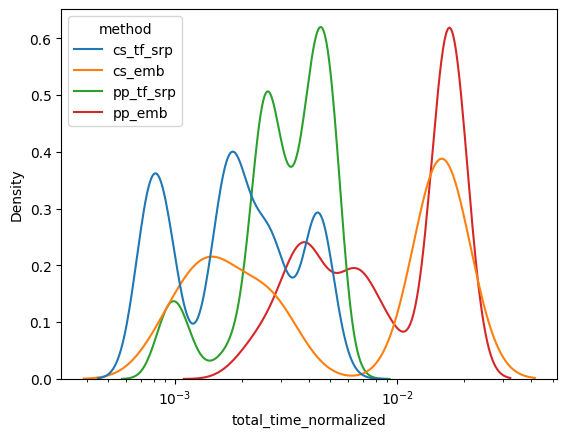

In [13]:
sns.kdeplot(df, x="total_time_normalized", hue="method", log_scale=True)